# Universidad EAFIT
## Maestría en Matemáticas Aplicadas

# Práctica 2 — Optimización Estocástica  
**Semestre 2025-2**

**Profesor:** Diego Fonseca  
**Plazo de entrega:** Lunes 3 de Noviembre de 2025 a las 11:59 pm  
**Modalidad:** Individual

> **Importante:** Cualquier intento de plagio será llevado a las instancias pertinentes de la universidad.

---

## Instrucciones

- Esta práctica se debe realizar de manera individual.
- El estudiante debe marcar correctamente su archivo con su trabajo. La primera línea de texto debe contener el **nombre y apellidos completos**, y **código de estudiante** (o **cédula** en caso de no tener código).
- Puede entregar un **archivo PDF** o un **Notebook**; este debe nombrarse de la siguiente manera:  
  `Practica1-OptSth-Apellido-Nombre`.
- Debe **justificar** sus procedimientos y soluciones, e **interpretar** sus resultados de acuerdo con el contexto de la actividad. No basta con llegar a las soluciones; es fundamental **explicarlas y argumentarlas**.
- Los archivos con sus soluciones se suben al **buzón de la actividad de EAFIT Interactiva**.

---

### Portafolios mean–CVaR con SAA vs. DRO (Wasserstein $p \in \{1,2\}$) en horizonte móvil y comparación con un benchmark equiponderado

### Contexto y propósito
El propósito de esta práctica es **construir y evaluar estrategias de inversión mean–risk** que combinan retorno esperado y control de riesgo de cola a través del **CVaR**. Se trabajará en un esquema de **horizonte móvil (rolling horizon)** con **rebalanceo diario**.

Se compararán dos enfoques de optimización:

1. **SAA (Sample Average Approximation)** del problema mean–CVaR.  
2. **DRO (Optimización Robusta Distribucionalmente)** sobre una **bola de Wasserstein** centrada en la distribución empírica con métrica euclidiana, para **$p = 1$** y **$p = 2$**.

El desempeño fuera de muestra se contrastará con un **benchmark equiponderado (Equal Weight, EW)**.

> **Meta central:** determinar si, en este problema, los enfoques **DRO** mejoran lo que se obtiene con **SAA** cuando ambos se aplican de manera coherente en un esquema rolling y con selección de hiperparámetros basada en datos.

---



## Acerca de los datos

- **Universo sugerido:** El conjunto de acciones líquidas es:  
  `AAPL, AMZN, BAC, BRK-A, CVX, DIS, HD, INTC, JNJ, JPM, KO, MA, MRK, MSFT, PFE, PG, UNH, VZ, WMT, XOM, GOOG`.
- **Frecuencia:** diaria.
- **Período:** 1/Ene/2008 – 14/Ago/2023.
- **Precios:** usar *Adjusted Close*. Alinear series por fecha y manejar valores faltantes de forma consistente (por ejemplo, eliminando activos con historial insuficiente en la ventana inicial).
- **Retornos simples:** para cada activo $j$ y día $t$,
  $
  \begin{equation}
  r_{j,t} = \frac{P_{j,t} - P_{j,t-1}}{P_{j,t-1}}.
  \end{equation}
  $
- **Pérdida del portafolio:** con pesos $\mathbf{x} \in \mathbb{R}^n$ y vector de retornos $\mathbf{r}_t \in \mathbb{R}^n$, defina
  $
  \begin{equation}
  L_t(\mathbf{x}) = -\, \mathbf{x}^\top \mathbf{r}_t.
  \end{equation}
  $
- **Restricciones del portafolio:** completamente invertido y **sin ventas en corto**:
  $
  \begin{equation}
  \sum_{j=1}^n x_j = 1,\quad x_j \ge 0.
  \end{equation}
  $

---


In [4]:
import yfinance as yf
import pandas as pd
import cvxpy as cp
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from tqdm.auto import tqdm  # funciona bien en Jupyter/VSCode

def download_prices(ticker="AAPL", start="2010-01-01", end=None, interval="1d", auto_adjust=True, csv_path=None):
    """
    Descarga precios históricos de un ticker desde Yahoo Finance.
    Devuelve un DataFrame con OHLCV y la fecha en una columna 'Date'.
    """
    if end is None:
        end = date.today().isoformat()
    df = yf.download(ticker, start=start, end=end, interval=interval, auto_adjust=auto_adjust, progress=False)
    df = df.reset_index()
    if csv_path:
        df.to_csv(csv_path, index=False)
        print(f"Guardado en: {csv_path}")
    return df

# ----------- MULTI-TICKERS -----------
tickers = [
    "AAPL","AMZN","BAC","BRK-A","CVX","DIS","HD",
    "INTC","JNJ","JPM","KO","MA","MRK","MSFT","PFE",
    "PG","UNH","VZ","WMT","XOM","GOOG"
]

start = "2008-01-01"
end   = "2023-08-14"
interval = "1d"
auto_adjust = True  # ajusta por splits/dividendos

# yfinance permite bajar varios tickers a la vez: columnas MultiIndex (OHLCV, Ticker)
raw = yf.download(
    tickers,
    start=start,
    end=end,
    interval=interval,
    auto_adjust=auto_adjust,
    progress=False,
)

# --- Nos quedamos con 'Close' y pasamos a formato "wide" (Date + columnas por ticker) ---
df_close_wide = raw["Close"].copy()  # columnas = tickers, índice = Date (DatetimeIndex)
df_close_wide = df_close_wide.reset_index()  # Date como columna
df_close_wide.columns.name = None      # limpia nombres de índice/columnas

# --- Retornos (pct_change) por columna (ticker) en wide ---
df_ret_wide = df_close_wide.copy()
df_ret_wide.iloc[:, 1:] = df_ret_wide.iloc[:, 1:].pct_change()  # todas las columnas menos 'Date'

# --- Versión "long": Date–Ticker–Close + Return ---
close_long = df_close_wide.melt(
    id_vars="Date", var_name="Ticker", value_name="Close"
)
ret_long = df_ret_wide.melt(
    id_vars="Date", var_name="Ticker", value_name="Return"
)
df_long = close_long.merge(ret_long, on=["Date", "Ticker"])

# Opción B: partir de df_close_wide (Date + columnas por ticker con Close)
returns_wide = df_close_wide.copy()
returns_wide.iloc[:, 1:] = returns_wide.iloc[:, 1:].pct_change()
returns_wide = returns_wide.dropna()  # quita primera fila vacía

returns_long = returns_wide.melt(
    id_vars="Date", var_name="Ticker", value_name="Return"
)

# (Opcional) guardar
returns_wide.to_csv("retornos_todos_wide.csv", index=False)
returns_long.to_csv("retornos_todos_long.csv", index=False)

returns_wide.head()

,Date,AAPL,AMZN,BAC,BRK-A,CVX,DIS,GOOG,HD,INTC,...,KO,MA,MRK,MSFT,PFE,PG,UNH,VZ,WMT,XOM
1,2008-01-03,0.000462,-0.010805,-0.006410,0.002154,0.012305,-0.002199,0.000204,-0.011107,-0.026825,...,0.010476,-0.011925,-0.000871,0.004259,0.011785,0.000000,0.004588,0.004629,-0.011088,0.003422
2,2008-01-04,-0.076335,-0.067430,-0.011166,-0.029370,-0.013318,-0.020145,-0.041338,-0.033307,-0.081070,...,0.001944,-0.051527,-0.008200,-0.027990,-0.015099,-0.004010,-0.016336,-0.018660,-0.014230,-0.018651
3,2008-01-07,-0.013385,0.000338,0.001255,-0.013284,-0.013069,0.000964,-0.011796,0.016426,0.009264,...,0.023605,-0.003380,0.018822,0.006690,0.017521,0.006525,0.015715,0.017605,0.018373,-0.009340
4,2008-01-08,-0.035971,-0.010583,-0.037344,-0.000112,-0.012808,-0.019897,-0.027062,-0.024833,-0.027098,...,0.004107,-0.012518,0.030042,-0.033516,0.010331,0.002621,-0.011780,-0.021668,-0.012672,-0.012826
5,2008-01-09,0.047591,-0.030269,0.008592,-0.024573,0.017812,-0.012443,0.034068,-0.000404,0.022013,...,0.026742,-0.006419,0.014079,0.029596,0.019174,-0.001926,-0.000356,0.011432,0.020231,0.016768


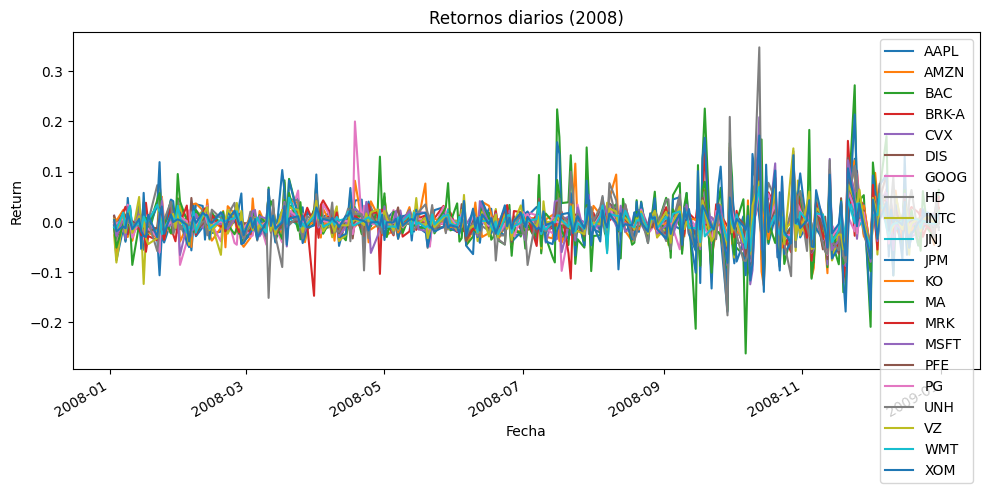

In [ ]:
dfp = returns_wide.copy()
dfp["Date"] = pd.to_datetime(dfp["Date"], errors="coerce")
dfp = dfp.set_index("Date").sort_index()

# Filtra únicamente el año elegido
dfp_year = dfp.loc[str(2008)]  # equivalente a: dfp[dfp.index.year == YEAR]

ax = dfp_year.plot(figsize=(10, 5))  # grafica todas las columnas (tickers)
ax.set_xlabel("Fecha")
ax.set_ylabel("Retornos")
ax.set_title(f"Retornos diarios ({2008})")
plt.tight_layout()
plt.show()


## Acerca de los parámetros del experimento

- **Esquema rolling:** utilice una **ventana de entrenamiento** de tamaño $N_{\text{train}}$ (específicamente, los datos entre **1/Ene/2008 y 14/Feb/2018**) para estimar $\mathbf{x}_t$ resolviendo el problema del día $t$, y evalúe el retorno con $\mathbf{r}_{t+1}$. Luego **deslice la ventana un día** y repita hasta el final del período de prueba.
- **Nivel de cola para CVaR:** use $\alpha = 0.8$. Interpretación: $ \text{CVaR}_\alpha $ con $\alpha = 0.8$ promedia las peores pérdidas del $20\%$ de la distribución (la cola de probabilidad $1 - \alpha = 0.2$). En esta práctica se busca **controlar esa cola**.
- **Aversión al riesgo ($\lambda$):** explore al menos la grilla sugerida  
  $\{0, 0.25, 0.5, 1, 2, 3, 5\}$.  
  Puede afinar la malla si lo considera adecuado.
- **Parámetro de robustez ($\varepsilon$) en DRO:** para cada $p \in \{1,2\}$ use una **malla fina** pero razonable de valores (p. ej., **8–12 puntos** desde 0 hasta un **máximo sensible** en sus datos). La **escala** de $\varepsilon$ depende de la **métrica** en el espacio de escenarios; documente su elección.
- **Wealth:** inicie con $W_0 = 1$ y actualice $W_{t+1} = W_t \bigl(1 + \mathbf{x}_t^\top \mathbf{r}_{t+1}\bigr)$. Reporte la **riqueza acumulada** para cada estrategia.

---


## Formulación que usted debe construir

### 1) Formule **SAA (mean–CVaR)**
En cada día, con los $N$ escenarios más recientes y $p_i = 1/N$, plantee:
$
\begin{aligned}
\min_{\mathbf{x},\, \gamma,\, \mathbf{z}\in \mathbb{R}^N}
&\quad \frac{1}{N}\sum_{i=1}^N L_i(\mathbf{x}) 
\;+\; \lambda \left(\gamma \;+\; \frac{1}{(1-\alpha)N}\sum_{i=1}^N z_i \right) \\
\text{sujeto a } &\quad z_i \ge L_i(\mathbf{x}) - \gamma,\quad z_i \ge 0,\quad i=1,\dots,N,\\
&\quad \sum_{j=1}^n x_j = 1,\quad x_j \ge 0.
\end{aligned}
$

### 2) Implemente el **esquema rolling** para SAA
- Evalúe **fuera de muestra** cada $\lambda$ de la grilla y **seleccione el mejor $\lambda$** según un criterio que usted debe **definir y justificar** (p. ej., riqueza final, CVaR realizado, *drawdown*, etc., o incluso apoyado gráficamente en las curvas de riqueza acumulada).



In [24]:
# ---------- parámetros para evitar el límite de licencia ----------
WINDOW_N = 200            # escenarios más recientes por ventana (ajusta 126/252/500)
REBALANCE_EVERY = 5       # 1 = rebalanceo diario; usa 5 para semanal aprox.
alpha = 0.8
lambda_grid = [0, 0.25, 0.5, 1, 2, 3, 5]
SHOW_PROGRESS = True

# ------------------------- función Gurobi -------------------------
def saa_mean_cvar_gurobi(R_window: np.ndarray, alpha=0.8, lam=1.0, threads=0, output=False):
    N, n = R_window.shape
    m = gp.Model("SAA_mean_CVaR")
    m.Params.OutputFlag = 1 if output else 0
    if threads > 0: m.Params.Threads = threads
    m.Params.Method = 1          # Dual Simplex
    m.Params.Presolve = 2

    x = m.addMVar(n, lb=0.0, name="x")
    gamma = m.addVar(lb=-GRB.INFINITY, name="gamma")
    z = m.addMVar(N, lb=0.0, name="z")

    L = - R_window @ x
    m.addConstr(gp.quicksum(x) == 1.0, name="budget")
    for i in range(N):
        m.addConstr(z[i] >= L[i] - gamma, name=f"cvar_{i}")

    obj = (1.0/N) * gp.quicksum(L) + lam * (gamma + (1.0/((1.0-alpha)*N)) * gp.quicksum(z))
    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()

    if m.Status != GRB.OPTIMAL:
        raise RuntimeError(f"Gurobi terminó con estado {m.Status}")
    w = np.array(x.X, dtype=float)
    w = np.maximum(w, 0); s = w.sum()
    return w/s if s > 0 else np.ones(n)/n

# ------------------------- preparar panel -------------------------
df = returns_wide.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").dropna().reset_index(drop=True)

mask_full = df.drop(columns=["Date"]).notna().all(axis=0)
tickers_ok = mask_full[mask_full].index.tolist()
# *** FIX: la línea rota por salto con '.' ***
df = df[["Date"] + tickers_ok].dropna().reset_index(drop=True)

dates = df["Date"].values
R_all = df.drop(columns=["Date"]).to_numpy(dtype=float)
T, n = R_all.shape
print(f"Panel: T={T}, n={n}")

# ventana de entrenamiento “histórica” fija hasta 2018-02-14
train_end_date = pd.Timestamp("2018-02-14")
idx_train_end = int(np.where(df["Date"] <= train_end_date)[0][-1])
print("train_end:", df["Date"].iloc[idx_train_end].date())

test_start = idx_train_end
test_end = T - 2
test_range = range(test_start, test_end + 1)

# ------------------------- métricas -------------------------
def realized_cvar(losses, alpha=0.8):
    if len(losses)==0: return np.nan
    # En NumPy >=1.22 usa 'method'; si tu entorno es más viejo, cambia a interpolation="higher"
    q = np.quantile(losses, alpha, method="higher")
    tail = losses[losses >= q]
    return tail.mean() if len(tail) else q

def max_drawdown(wealth):
    peak = np.maximum.accumulate(wealth)
    dd = (wealth - peak) / peak
    return float(dd.min())

# ------------------------- rolling con ventana capada -------------------------
results = {}
lam_iter = lambda_grid
if SHOW_PROGRESS:
    lam_iter = tqdm(lambda_grid, desc="Barrido de λ", leave=True)

for lam in lam_iter:
    wealth = [1.0]
    rets, losses, turnovers = [], [], []
    prev_w = None

    # rebalanceo con frecuencia REBALANCE_EVERY
    w_hold = None
    t_iter = test_range
    if SHOW_PROGRESS:
        t_iter = tqdm(test_range, desc=f"Rolling λ={lam}", leave=False)

    for t in t_iter:
        # ¿rebalanceamos hoy?
        if (t - test_start) % REBALANCE_EVERY == 0 or w_hold is None:
            start_all = max(0, t - (WINDOW_N - 1))     # cap de N escenarios
            R_train = R_all[start_all:t+1, :]
            try:
                w_hold = saa_mean_cvar_gurobi(R_train, alpha=alpha, lam=lam, threads=0, output=False)
            except gp.GurobiError as e:
                if "size-limited license" in str(e).lower():
                    raise RuntimeError(
                        "La ventana aún es demasiado grande para tu licencia. "
                        "Reduce WINDOW_N (p.ej., 126/252) y/o disminuye el número de activos."
                    ) from e
                else:
                    raise

            # turnover (si aplica)
            if prev_w is None:
                turnovers.append(np.nan)
            else:
                turnovers.append(0.5*np.sum(np.abs(w_hold - prev_w)))
            prev_w = w_hold

        # aplicar pesos al día siguiente
        r_next = R_all[t+1, :]
        rp = float(w_hold @ r_next)
        rets.append(rp); losses.append(-rp)
        wealth.append(wealth[-1]*(1+rp))

    wealth = np.asarray(wealth)
    rets = np.asarray(rets); losses = np.asarray(losses); turnovers = np.asarray(turnovers)
    results[lam] = dict(
        wealth=wealth,
        dates_oos=df["Date"].iloc[test_start+1:test_start+1+len(rets)].values,
        mean_ret=np.nanmean(rets),
        vol=np.nanstd(rets, ddof=1),
        cvar_real=realized_cvar(losses, alpha=alpha),
        max_dd=max_drawdown(wealth),
        avg_turnover=np.nanmean(turnovers),
        final_wealth=float(wealth[-1])
    )

# benchmark equiponderado (con barra si quieres)
wealth_ew = [1.0]
t_bench = test_range
if SHOW_PROGRESS:
    t_bench = tqdm(test_range, desc="Benchmark EW", leave=False)
for t in t_bench:
    rp = float((np.ones(n)/n) @ R_all[t+1, :])
    wealth_ew.append(wealth_ew[-1]*(1+rp))
wealth_ew = np.array(wealth_ew)

best_lambda = max(results.keys(), key=lambda L: results[L]["final_wealth"])
print(f"Mejor λ (Wealth final): {best_lambda}  -> {results[best_lambda]['final_wealth']:.3f}")

summary = pd.DataFrame([
    ["EW", np.nan, np.nan, np.nan, max_drawdown(wealth_ew), np.nan, float(wealth_ew[-1])]
] + [
    [f"SAA λ={lam}", r["mean_ret"], r["vol"], r["cvar_real"], r["max_dd"], r["avg_turnover"], r["final_wealth"]]
    for lam, r in results.items()
], columns=["Estrategia","RetProm","Vol","CVaR0.8 (real)","MaxDD","TurnoverProm","WealthFinal"])
print(summary.to_string(index=False))


Panel: T=3929, n=21
train_end: 2018-02-14


Barrido de λ: 100%|██████████| 7/7 [01:49<00:00, 15.65s/it]
                                                      

Mejor λ (Wealth final): 0  -> 2.166
Estrategia  RetProm      Vol  CVaR0.8 (real)     MaxDD  TurnoverProm  WealthFinal
        EW      NaN      NaN             NaN -0.306638           NaN     2.040657
   SAA λ=0 0.000762 0.020077        0.026682 -0.341630      0.173913     2.165957
SAA λ=0.25 0.000618 0.012003        0.015101 -0.217457      0.168503     2.125452
 SAA λ=0.5 0.000517 0.010877        0.013656 -0.215287      0.137065     1.880670
   SAA λ=1 0.000481 0.010358        0.013119 -0.194958      0.116409     1.804121
   SAA λ=2 0.000442 0.010198        0.012914 -0.204895      0.109880     1.712629
   SAA λ=3 0.000431 0.010156        0.012872 -0.210566      0.107656     1.687633
   SAA λ=5 0.000432 0.010079        0.012806 -0.209696      0.104574     1.691801


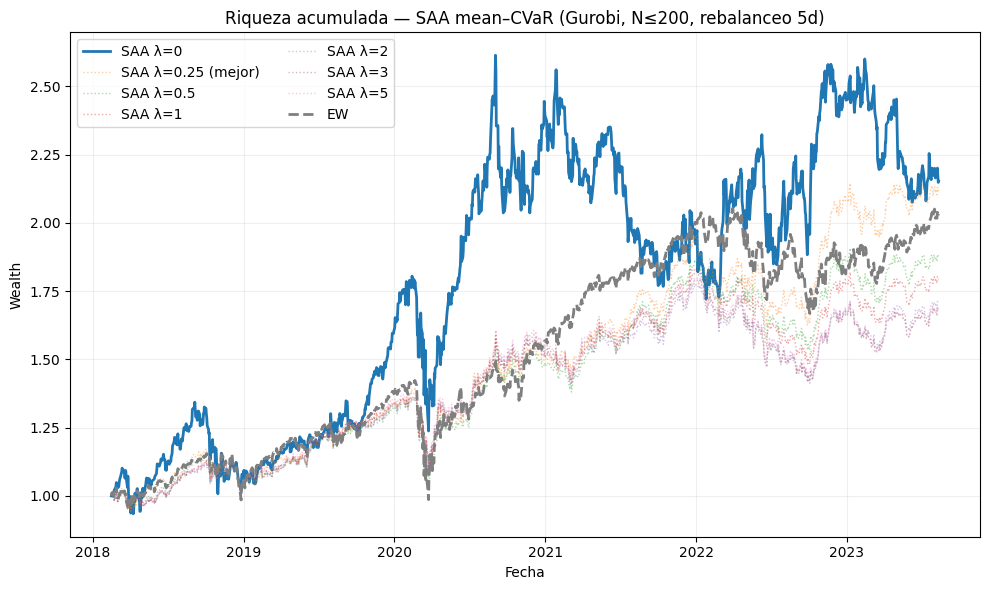

In [26]:
# gráfica
plt.figure(figsize=(10,6))
dates_oos = results[best_lambda]["dates_oos"]
for lam, r in results.items():
    ls = "-" if lam==best_lambda else ":"
    lw = 2 if lam==best_lambda else 1
    alpha_plot = 1.0 if lam==best_lambda else 0.4
    label = f"SAA λ={lam}" + (" (mejor)" if lam==0.25 else "")
    plt.plot(dates_oos, r["wealth"][:-1], ls=ls, lw=lw, alpha=alpha_plot, label=label)
plt.plot(dates_oos, wealth_ew[:len(dates_oos)], ls="--", lw=2, label="EW")
plt.title(f"Riqueza acumulada — SAA mean–CVaR (Gurobi, N≤{WINDOW_N}, rebalanceo {REBALANCE_EVERY}d)")
plt.xlabel("Fecha"); plt.ylabel("Wealth"); plt.grid(True, alpha=0.2); plt.legend(ncol=2)
plt.tight_layout(); plt.show()


### 3) Formule **DRO** (Wasserstein $p = 1$ y $p = 2$)
- Considere el problema mean–CVaR donde la **esperanza** se toma en la **peor distribución** dentro de la **bola de Wasserstein** de radio $\varepsilon$ centrada en la empírica (métrica euclidiana en el espacio de escenarios).
- Use las **reformulaciones** vistas en clase para resolver los problemas resultantes (**recordatorio:** típicamente **LP** para $p=1$ y **SOCP** para $p=2$, dependiendo de la instancia).

### 4) Implemente el **esquema rolling** para DRO
- **Fije $\lambda$** en el **mejor valor hallado con SAA** y, para cada $p \in \{1,2\}$, **explore una malla de $\varepsilon$**.  
- Seleccione el **mejor $\varepsilon$** con el mismo espíritu del punto 2 y **justifique** su criterio.

### 5) **Benchmarks**
- Construya y evalúe el **portafolio equiponderado (EW)** en el **mismo esquema rolling**.  
- Puede añadir **benchmarks adicionales** si lo considera útil.

---

In [14]:
# ============================ imports ============================
import numpy as np
import cvxpy as cp

try:
    from tqdm import tqdm
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False

# ============================ métricas ============================
def realized_cvar(losses: np.ndarray, alpha: float = 0.8) -> float:
    losses = np.asarray(losses, dtype=float)
    if losses.size == 0:
        return np.nan
    q = np.quantile(losses, alpha)
    tail = losses[losses >= q]
    return float(np.mean(tail)) if tail.size > 0 else float(q)

def max_drawdown(wealth: np.ndarray) -> float:
    wealth = np.asarray(wealth, dtype=float)
    if wealth.size == 0:
        return np.nan
    peak = np.maximum.accumulate(wealth)
    dd = (wealth - peak) / peak
    return float(-np.min(dd))

# ============================ DRO W1 (cvxpy) ============================
def dro_w1_mean_cvar_cvxpy(R_window: np.ndarray, alpha=0.8, lam=1.0, eps=0.0,
                           solver="ECOS", verbose=False):
    """
    DRO Wasserstein p=1 (euclídea) para mean–CVaR con cvxpy.
    R_window: N x n (escenarios por filas).
    """
    R = np.asarray(R_window, dtype=float)
    N, n = R.shape

    x = cp.Variable(n, nonneg=True)
    gamma = cp.Variable()
    z = cp.Variable(N, nonneg=True)
    t = cp.Variable(nonneg=True)             # t >= ||x||_2

    # pérdidas L_i = -r_i^T x
    losses = -R @ x

    constraints = []
    constraints += [cp.sum(x) == 1.0]
    constraints += [z >= losses - gamma]     # z_i >= L_i - gamma
    constraints += [cp.norm2(x) <= t]        # SOC

    # constante Lipschitz respecto a xi
    c_lip = max(1.0, lam / (1.0 - alpha))

    obj = (1.0/N) * cp.sum(losses) \
          + lam * ( gamma + (1.0 / ((1.0 - alpha) * N)) * cp.sum(z) ) \
          + eps * c_lip * t

    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver=cp.ECOS if solver=="ECOS" else cp.SCS, verbose=verbose)

    return {
        "status": prob.status,
        "obj": prob.value if prob.status in ("optimal", "optimal_inaccurate") else None,
        "x": x.value if x.value is not None else None,
        "gamma": gamma.value if gamma.value is not None else None,
        "z": z.value if z.value is not None else None,
        "t": t.value if t.value is not None else None
    }

# ============================ DRO W2 (cvxpy) ============================
def dro_w2_mean_cvar_cvxpy(R_window: np.ndarray, alpha=0.8, lam=1.0, eps=0.0,
                           solver="ECOS", verbose=False):
    """
    DRO Wasserstein p=2 (euclídea) para mean–CVaR con cvxpy (SOCP dual compacto).
    Usa parámetros (a_k, b_k) y el cono: ||(2x, lam_dual - z_aux)||_2 <= lam_dual + z_aux.
    """
    R = np.asarray(R_window, dtype=float)
    N, n = R.shape

    x = cp.Variable(n, nonneg=True)
    tau = cp.Variable()              # ~ gamma
    s = cp.Variable(N)               # epígrafes por escenario (libres)
    lam_dual = cp.Variable(nonneg=True)
    z_aux = cp.Variable(nonneg=True)

    a1, b1 = -1.0, 0.0
    a2, b2 = -(lam / (1.0 - alpha)), lam

    lin_rx = -R @ x  # porque L_i = -r_i^T x

    constraints = []
    constraints += [cp.sum(x) == 1.0]
    # restricciones epi para cada i y k
    constraints += [ (a1*a1/4.0)*z_aux + a1*lin_rx + b1*tau <= s ]
    constraints += [ (a2*a2/4.0)*z_aux + a2*lin_rx + b2*tau <= s ]

    # SOC: ||(2x, lam_dual - z_aux)||_2 <= lam_dual + z_aux
    v = cp.hstack([2.0*x, lam_dual - z_aux])
    constraints += [ cp.norm2(v) <= lam_dual + z_aux ]

    obj = lam_dual * (eps ** 2) + (1.0 / N) * cp.sum(s)
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver=cp.ECOS if solver=="ECOS" else cp.SCS, verbose=verbose)

    return {
        "status": prob.status,
        "obj": prob.value if prob.status in ("optimal", "optimal_inaccurate") else None,
        "x": x.value if x.value is not None else None,
        "tau": tau.value if tau.value is not None else None,
        "lam_dual": lam_dual.value if lam_dual.value is not None else None,
        "z_aux": z_aux.value if z_aux.value is not None else None,
        "s": s.value if s.value is not None else None
    }

# ============================ runner rolling ============================
def run_rolling_dro(R_all: np.ndarray,
                    dates,                     # array-like o None
                    test_start: int,
                    test_end:   int,
                    window_n:   int = 252,
                    rebalance_every: int = 1,
                    alpha: float = 0.8,
                    lam: float = 1.0,
                    eps_grid = (0.5,1,1.5,2,2.5,3),
                    dro_solver = dro_w1_mean_cvar_cvxpy,  # <- por defecto W1/ECOS
                    solver_name="ECOS",
                    show_progress: bool = True):
    """
    Ejecuta rolling para una malla de eps con el solver DRO indicado (W1 o W2).
    """
    R_all = np.asarray(R_all, dtype=float)
    n_days, n_assets = R_all.shape
    assert 0 <= test_start < test_end < n_days-1, "rangos de test inválidos"

    results = {}
    eps_iter = list(eps_grid)
    if show_progress and _HAS_TQDM:
        eps_iter = tqdm(eps_iter, desc="Barrido ε", leave=True)

    test_range = range(test_start, test_end+1)

    for ep in eps_iter:
        wealth = [1.0]
        rets, losses, turnovers = [], [], []
        prev_w = None
        w_hold = None

        t_iter = test_range
        if show_progress and _HAS_TQDM:
            t_iter = tqdm(test_range, desc=f"Rolling ε={ep}", leave=False)

        for t in t_iter:
            if (t - test_start) % rebalance_every == 0 or w_hold is None:
                start_all = max(0, t - (window_n - 1))
                R_train = R_all[start_all:t+1, :]

                res = dro_solver(R_train, alpha=alpha, lam=lam, eps=ep,
                                 solver=solver_name, verbose=False)
                if res["status"] not in ("optimal", "optimal_inaccurate"):
                    raise RuntimeError(f"Optimización no óptima (status={res['status']}) en t={t}, eps={ep}")
                w_hold = res["x"].reshape(-1)

                if prev_w is None:
                    turnovers.append(np.nan)
                else:
                    turnovers.append(0.5 * np.sum(np.abs(w_hold - prev_w)))
                prev_w = w_hold

            r_next = R_all[t+1, :]
            rp = float(w_hold @ r_next)
            rets.append(rp); losses.append(-rp)
            wealth.append(wealth[-1]*(1+rp))

        wealth = np.asarray(wealth)
        rets = np.asarray(rets); losses = np.asarray(losses)
        turnovers = np.asarray(turnovers)

        dates_oos = None if dates is None else np.asarray(dates)[test_start+1:test_start+1+len(rets)]

        results[ep] = dict(
            wealth=wealth,
            dates_oos=dates_oos,
            mean_ret=float(np.nanmean(rets)),
            vol=float(np.nanstd(rets, ddof=1)),
            cvar_real=float(realized_cvar(losses, alpha=alpha)),
            max_dd=float(max_drawdown(wealth)),
            avg_turnover=float(np.nanmean(turnovers)),
            final_wealth=float(wealth[-1])
        )
    return results

def pick_best_epsilon(results: dict, criterion: str = "final_wealth", maximize: bool = True):
    keys = list(results.keys())
    vals = np.array([results[k][criterion] for k in keys], dtype=float)
    j = int(np.nanargmax(vals)) if maximize else int(np.nanargmin(vals))
    return keys[j], results[keys[j]][criterion]

# ============================ ejemplo mínimo ============================
if __name__ == "__main__":
    np.random.seed(0)
    n_days, n_assets = 800, 10
    R_all = 0.0005 + 0.01*np.random.randn(n_days, n_assets)
    dates = np.arange(n_days)

    WINDOW_N = 252
    REBALANCE_EVERY = 1
    alpha = 0.8
    lambda_star = 0.25
    epsilon_grid = np.linspace(0.001, 0.01, 10)
    test_start, test_end = 500, 780

    # --- W1 con ECOS (recomendado) ---
    res_w1 = run_rolling_dro(R_all, dates,
                             test_start, test_end,
                             window_n=WINDOW_N,
                             rebalance_every=REBALANCE_EVERY,
                             alpha=alpha, lam=lambda_star,
                             eps_grid=epsilon_grid,
                             dro_solver=dro_w1_mean_cvar_cvxpy,
                             solver_name="ECOS",
                             show_progress=True)
    best_eps_w1, val_w1 = pick_best_epsilon(res_w1, "final_wealth", True)
    print(f"[W1-ECOS] Mejor ε: {best_eps_w1}  final_wealth={val_w1:.4f}")

    # --- W2 con ECOS (puede ser más pesado; úsalo si necesitas) ---
    res_w2 = run_rolling_dro(R_all, dates,
                             test_start, test_end,
                             window_n=WINDOW_N,
                             rebalance_every=REBALANCE_EVERY,
                             alpha=alpha, lam=lambda_star,
                             eps_grid=epsilon_grid,
                             dro_solver=dro_w2_mean_cvar_cvxpy,
                             solver_name="ECOS",
                             show_progress=True)
    best_eps_w2, val_w2 = pick_best_epsilon(res_w2, "final_wealth", True)
    print(f"[W2-ECOS] Mejor ε: {best_eps_w2}  final_wealth={val_w2:.4f}")
    

Barrido ε:   0%|          | 0/10 [00:00<?, ?it/s]

/home/ebrios/anaconda3/envs/optest/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Barrido ε: 100%|██████████| 10/10 [00:30<00:00,  3.08s/it]


[W1-ECOS] Mejor ε: 0.001  final_wealth=1.1839


Barrido ε: 100%|██████████| 10/10 [00:52<00:00,  5.22s/it]

[W2-ECOS] Mejor ε: 0.01  final_wealth=1.1078


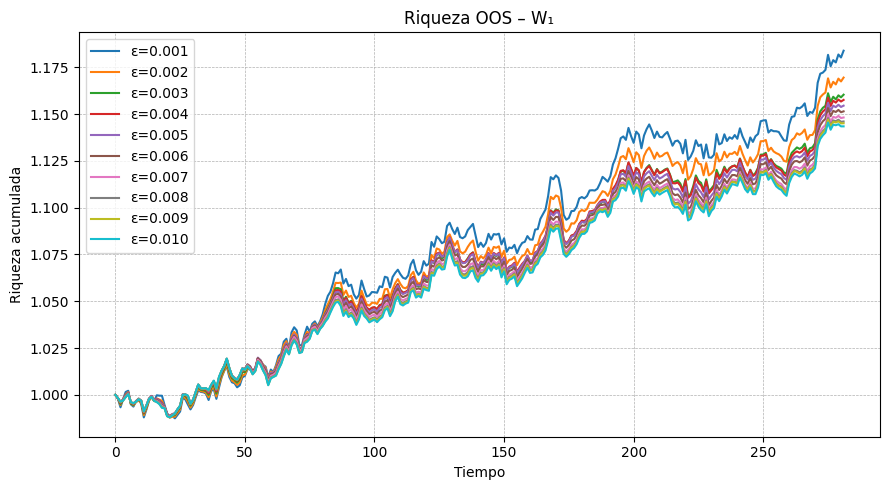

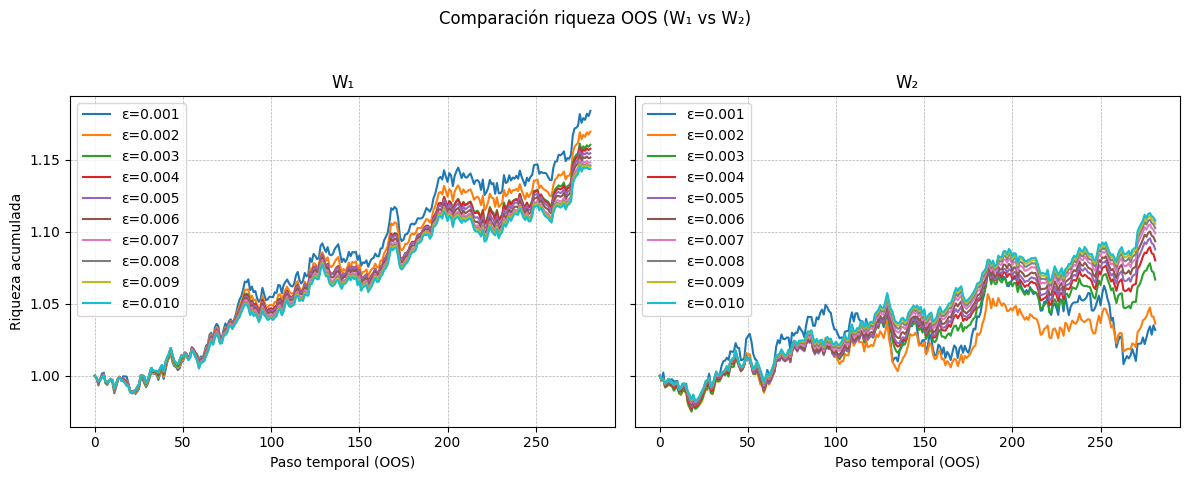

   epsilon  final_wealth  mean_ret       vol  cvar_real    max_dd  \
0    0.001      1.183855  0.000608  0.003693   0.004622  0.021227   
1    0.002      1.169498  0.000563  0.003350   0.004198  0.017512   
2    0.003      1.160364  0.000534  0.003157   0.003986  0.017034   
3    0.004      1.157572  0.000526  0.003056   0.003863  0.017040   
4    0.005      1.154503  0.000516  0.003003   0.003792  0.017851   

   avg_turnover  
0      0.027457  
1      0.019693  
2      0.015038  
3      0.012060  
4      0.010341  
   epsilon  final_wealth  mean_ret       vol  cvar_real    max_dd  \
9    0.010      1.107807  0.000368  0.002859   0.003738  0.021659   
8    0.009      1.105525  0.000361  0.002877   0.003771  0.022107   
7    0.008      1.102626  0.000352  0.002902   0.003823  0.022682   
6    0.007      1.098809  0.000340  0.002942   0.003903  0.023448   
5    0.006      1.093422  0.000322  0.003006   0.004026  0.024532   

   avg_turnover  
9      0.006885  
8      0.007708  
7      0

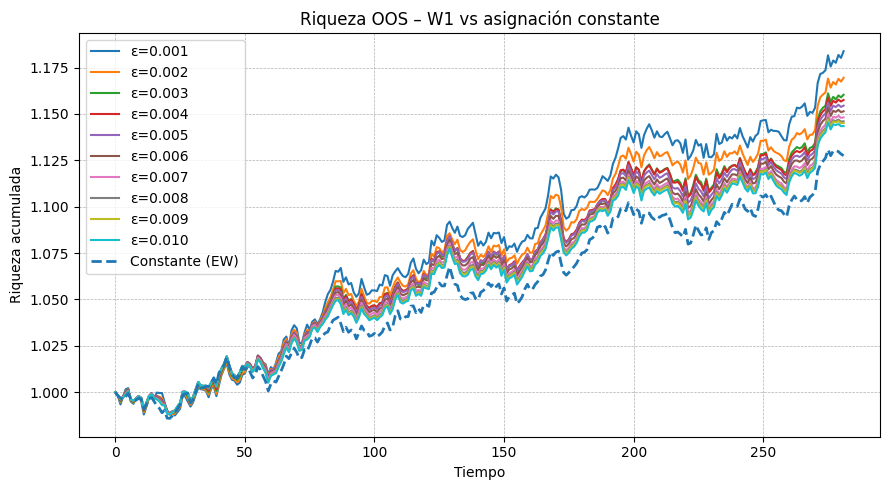

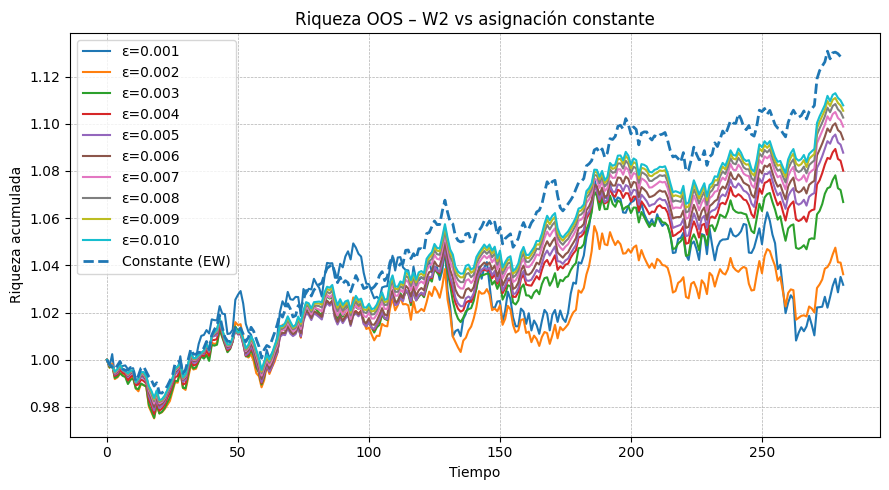

             label  final_wealth  mean_ret       vol    max_dd  avg_turnover
0          ε=0.001      1.183855  0.000608  0.003693  0.021227      0.027457
1          ε=0.002      1.169498  0.000563  0.003350  0.017512      0.019693
2          ε=0.003      1.160364  0.000534  0.003157  0.017034      0.015038
3          ε=0.004      1.157572  0.000526  0.003056  0.017040      0.012060
4          ε=0.005      1.154503  0.000516  0.003003  0.017851      0.010341
5          ε=0.006      1.151463  0.000506  0.002965  0.018194      0.009217
6          ε=0.007      1.148180  0.000496  0.002936  0.018335      0.008011
7          ε=0.008      1.146048  0.000489  0.002913  0.018587      0.007215
8          ε=0.009      1.145105  0.000486  0.002895  0.018741      0.006353
9          ε=0.010      1.143447  0.000481  0.002881  0.018871      0.005867
10  Constante (EW)      1.127508  0.000431  0.002806  0.020283      0.000000
             label  final_wealth  mean_ret       vol    max_dd  avg_turnover

In [15]:
# ======= plots_y_resumen_dro.py =======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _iter_eps_sorted(results: dict):
    """Itera (epsilon, info) con epsilon ordenado numéricamente si es posible."""
    def _to_float(x):
        try:
            return float(x)
        except Exception:
            return x
    return [(k, results[k]) for k in sorted(results.keys(), key=_to_float)]

def _fmt_eps(ep, decimals: int = 3) -> str:
    try:
        return f"{float(ep):.{decimals}f}"
    except Exception:
        return str(ep)


def summarize_results(results: dict) -> pd.DataFrame:
    """
    Construye una tabla resumen a partir del dict de resultados:
    { eps: {wealth, dates_oos, final_wealth, mean_ret, vol, cvar_real, max_dd, avg_turnover}, ... }
    """
    rows = []
    for ep, info in _iter_eps_sorted(results):
        rows.append({
            "epsilon": ep,
            "final_wealth": float(info.get("final_wealth", np.nan)),
            "mean_ret": float(info.get("mean_ret", np.nan)),
            "vol": float(info.get("vol", np.nan)),
            "cvar_real": float(info.get("cvar_real", np.nan)),
            "max_dd": float(info.get("max_dd", np.nan)),
            "avg_turnover": float(info.get("avg_turnover", np.nan)),
        })
    return pd.DataFrame(rows)

def plot_wealth_curves(results: dict,
                       title: str = "Crecimiento de riqueza por ε",
                       use_dates: bool = True,
                       save_path: str | None = None,
                       show: bool = True):
    """
    Grafica riqueza acumulada para cada ε en 'results'.
    - Si hay 'dates_oos' y use_dates=True, se usan como eje X (agrega el punto inicial al principio).
    """
    plt.figure(figsize=(9, 5))
    for ep, info in _iter_eps_sorted(results):
        wealth = np.asarray(info["wealth"], dtype=float)
        dates = info.get("dates_oos", None)
        if use_dates and dates is not None and hasattr(dates, "__len__") and len(dates) == len(wealth) - 1:
            # construimos eje X con un punto inicial "t0"
            x = np.arange(len(dates) + 1)  # si quieres fechas reales, anteponemos un dummy
            plt.plot(x, wealth, label=f"ε={_fmt_eps(ep, 3)}")
        else:
            x = np.arange(len(wealth))
            plt.plot(x, wealth, label=f"ε={_fmt_eps(ep, 3)}")

    plt.title(title)
    plt.xlabel("Paso temporal (OOS)" if not (use_dates and dates is not None) else "Tiempo")
    plt.ylabel("Riqueza acumulada")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    if show:
        plt.show()
    plt.close()

def plot_compare_two(results_a: dict, results_b: dict,
                     label_a: str = "W₁", label_b: str = "W₂",
                     title: str = "Riqueza por ε (comparación p=1 vs p=2)",
                     use_dates: bool = True,
                     save_path: str | None = None,
                     show: bool = True):
    """
    Dibuja dos paneles: izquierda (results_a), derecha (results_b).
    Útil para comparar p=1 vs p=2.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    for ax, (results, lab) in zip(axes, [(results_a, label_a), (results_b, label_b)]):
        for ep, info in _iter_eps_sorted(results):
            wealth = np.asarray(info["wealth"], dtype=float)
            dates = info.get("dates_oos", None)
            if use_dates and dates is not None and hasattr(dates, "__len__") and len(dates) == len(wealth)-1:
                x = np.arange(len(dates) + 1)
                ax.plot(x, wealth, label=f"ε={_fmt_eps(ep, 3)}")
            else:
                x = np.arange(len(wealth))
                ax.plot(x, wealth, label=f"ε={_fmt_eps(ep, 3)}")
        ax.set_title(lab)
        ax.set_xlabel("Paso temporal (OOS)")
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax.legend()

    axes[0].set_ylabel("Riqueza acumulada")
    fig.suptitle(title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_path:
        fig.savefig(save_path, dpi=150)
    if show:
        plt.show()
    plt.close(fig)

# -------- métrica simple ----------
def max_drawdown(wealth: np.ndarray) -> float:
    peak = np.maximum.accumulate(wealth)
    dd = (wealth - peak) / peak
    return float(-np.min(dd))

# -------- asignación constante ----------
def constant_allocation_result(R_all: np.ndarray,
                               test_start: int,
                               test_end: int,
                               weights: np.ndarray | None = None,
                               dates=None,
                               label: str = "Constante (EW)"):
    """
    Construye el resultado OOS para una asignación constante:
    - weights=None => equal-weight en todos los activos
    - weights: vector (n,) no negativo que suma 1
    Devuelve un dict con el mismo formato que tus resultados por ε.
    """
    R_all = np.asarray(R_all, dtype=float)
    n_assets = R_all.shape[1]
    if weights is None:
        w = np.ones(n_assets) / n_assets
    else:
        w = np.asarray(weights, dtype=float)
        w = np.clip(w, 0, None)
        w = w / w.sum()

    wealth = [1.0]
    rets = []
    for t in range(test_start, test_end + 1):
        r_next = R_all[t+1, :]
        rp = float(w @ r_next)
        rets.append(rp)
        wealth.append(wealth[-1] * (1.0 + rp))

    wealth = np.asarray(wealth)
    dates_oos = None if dates is None else np.asarray(dates)[test_start+1:test_start+1+len(rets)]
    return {
        "wealth": wealth,
        "dates_oos": dates_oos,
        "final_wealth": float(wealth[-1]),
        "mean_ret": float(np.mean(rets)),
        "vol": float(np.std(rets, ddof=1)),
        "max_dd": float(max_drawdown(wealth)),
        "avg_turnover": 0.0,   # fijo en 0: no hay rebalanceos
        "_label": label
    }

# -------- ploteo con constante ----------
def plot_wealth_curves_with_constant(results: dict,
                                     constant_res: dict | None = None,
                                     title: str = "Crecimiento de riqueza por ε",
                                     use_dates: bool = True,
                                     save_path: str | None = None,
                                     show: bool = True,
                                     decimals: int = 3):
    """
    Grafica las curvas de riqueza por ε y (opcional) una curva adicional de asignación constante.
    """
    plt.figure(figsize=(9, 5))

    # DRO por ε (labels con 3 decimales)
    for ep, info in _iter_eps_sorted(results):
        wealth = np.asarray(info["wealth"], dtype=float)
        dates = info.get("dates_oos", None)
        lbl = f"ε={_fmt_eps(ep, decimals)}"
        if use_dates and dates is not None and hasattr(dates, "__len__") and len(dates) == len(wealth) - 1:
            x = np.arange(len(dates) + 1)
        else:
            x = np.arange(len(wealth))
        plt.plot(x, wealth, label=lbl)

    # Curva constante opcional
    if constant_res is not None:
        w_const = np.asarray(constant_res["wealth"], dtype=float)
        d_const = constant_res.get("dates_oos", None)
        lblc = constant_res.get("_label", "Constante")
        if use_dates and d_const is not None and hasattr(d_const, "__len__") and len(d_const) == len(w_const) - 1:
            xc = np.arange(len(d_const) + 1)
        else:
            xc = np.arange(len(w_const))
        plt.plot(xc, w_const, linestyle="--", linewidth=2.0, label=lblc)

    plt.title(title)
    plt.xlabel("Tiempo")
    plt.ylabel("Riqueza acumulada")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    if show:
        plt.show()
    plt.close()

# -------- tabla resumen combinada (opcional) ----------
def summarize_with_constant(results: dict, constant_res: dict | None = None) -> pd.DataFrame:
    rows = []
    for ep, info in _iter_eps_sorted(results):
        rows.append({"label": f"ε={_fmt_eps(ep,3)}",
                     "final_wealth": float(info.get("final_wealth", np.nan)),
                     "mean_ret": float(info.get("mean_ret", np.nan)),
                     "vol": float(info.get("vol", np.nan)),
                     "max_dd": float(info.get("max_dd", np.nan)),
                     "avg_turnover": float(info.get("avg_turnover", np.nan))})
    if constant_res is not None:
        rows.append({"label": constant_res.get("_label", "Constante"),
                     "final_wealth": float(constant_res.get("final_wealth", np.nan)),
                     "mean_ret": float(constant_res.get("mean_ret", np.nan)),
                     "vol": float(constant_res.get("vol", np.nan)),
                     "max_dd": float(constant_res.get("max_dd", np.nan)),
                     "avg_turnover": float(constant_res.get("avg_turnover", np.nan))})
    return pd.DataFrame(rows)





# 1) Gráfica simple (p. ej., W₁)
plot_wealth_curves(res_w1, title="Riqueza OOS – W₁", save_path="wealth_w1.png")

# 2) Comparar W₁ vs W₂
plot_compare_two(res_w1, res_w2,
                 label_a="W₁", label_b="W₂",
                 title="Comparación riqueza OOS (W₁ vs W₂)",
                 save_path="wealth_compare_w1_w2.png")

# 3) Resumen y CSV
df_w1 = summarize_results(res_w1)
df_w2 = summarize_results(res_w2)
print(df_w1.sort_values("final_wealth", ascending=False).head())
print(df_w2.sort_values("final_wealth", ascending=False).head())

# Supón que ya tienes:
# R_all, test_start, test_end, res_w1  (o res_w2), y opcionalmente 'dates'

# 1) Construir benchmark constante (equal-weight)
const_res = constant_allocation_result(R_all, test_start, test_end, weights=None, dates=dates,
                                       label="Constante (EW)")

# 2) Graficar DRO + constante (labels ε con 3 decimales)
plot_wealth_curves_with_constant(res_w1, constant_res=const_res,
                                 title="Riqueza OOS – W1 vs asignación constante",
                                 save_path="wealth_w1_constante.png")

plot_wealth_curves_with_constant(res_w2, constant_res=const_res,
                                 title="Riqueza OOS – W2 vs asignación constante",
                                 save_path="wealth_w2_constante.png")

# 3) Tabla resumen conjunta
df_sum = summarize_with_constant(res_w1, const_res)
print(df_sum.sort_values("final_wealth", ascending=False))
df_sum = summarize_with_constant(res_w2, const_res)
print(df_sum.sort_values("final_wealth", ascending=False))



## Productos esperados (entregables)

### 1. **Memoria técnica (PDF)**
- Describa el **universo de activos**, **período**, **ventana $N_{\text{train}}$**, **frecuencia de rebalanceo**, y cualquier **filtrado** aplicado.
- Explique con precisión el significado de $\alpha = 0.8$ (**cola del 20%**) y cómo **interactúa con $\lambda$**.
- Documente sus **grillas** de $\lambda$ y $\varepsilon$, el **criterio de selección** y la **lógica del esquema rolling**.
- **Reflexión metodológica (sin implementación adicional):** proponga y discuta **cómo se podrían elegir $\lambda$ y $\varepsilon$ sin mirar fuera de muestra**. ¿Hay **técnicas estadísticas** (especialmente **no‑paramétricas**) que podrían ayudar? **No se requiere implementarlas**; sí **proponer y argumentar**.

### 2. **Resultados y visualizaciones**
- **Gráfica de riqueza acumulada** (mismo eje temporal, es decir, en los días que **no** se usaron para entrenar) con:
  - **SAA** con su **mejor $\lambda$**.
  - **DRO–$p=1$** con su **mejor $\varepsilon$** (y la $\lambda$ elegida por SAA).
  - **DRO–$p=2$** con su **mejor $\varepsilon$** (y la $\lambda$ elegida por SAA).
  - **Benchmark EW**.
- **Tabla resumen fuera de muestra:** retorno promedio, volatilidad, $ \text{CVaR}_{0.8} $ realizado, **máximo drawdown**, **turnover** promedio (si lo calcula) y **riqueza final**.

### 3. **Interpretación**
- Explique la **solución** en el **contexto** del problema, concretamente:
  - Compare el **comportamiento** de **SAA** y de **DRO‑$p$** (con sus **mejores hiperparámetros**) frente a **EW**.  
  - ¿En qué **regiones del tiempo** se observan **diferencias claras**?  
  - ¿Qué sugiere el **CVaR realizado** sobre el **control de caídas**?
- Discuta **posibles limitaciones** y **cómo se mitigaron**.

### 4. **Repositorio reproducible**
- Sea **ordenado** al momento de entregar sus resultados; el **script** debe estar **completo y ejecutado** (con **parámetros establecidos**), incluyendo la **forma de obtener los datos**, y un **README** con instrucciones para replicar o con **comentarios claros**.
- Reporte el **solver** utilizado para cada formulación.